# Beta Variational Autoencoder (simple dots long training)

## Setup

In [1]:
import sconce
print(f"This notebook was run using sconce version {sconce.__version__}.")

This notebook was run using sconce version 0.12.0.


In [2]:
from matplotlib import pyplot as plt

def plot_trace(trainer, figure_width=15, num_cols=11, image_height=1.75, index=0):
    sample, target = trainer.test_data_generator.dataset[index]
    sample_batch = sample[None].cuda()
    trainer.model.train(False)
    mu, logvar = trainer.model.encode(sample_batch)
    z = trainer.model.reparameterize(mu, logvar)
    
    num_rows = z.shape[-1]
    num_cols = num_cols
    
    fig = plt.figure(figsize=(figure_width, image_height * num_rows))
    
    for i in range(z.shape[-1]):
        z_i_values = np.linspace(-3.0, 3.0, num_cols)
        z_i = z[0][i].detach().cpu().numpy()
        z_diffs = np.abs((z_i_values - z_i))
        j_min = np.argmin(z_diffs)
        for j in range(num_cols):
            z_i_value = z_i_values[j]
            if j != j_min:
                z[0][i] = z_i_value
            else:
                z[0][i] = float(z_i)
                
            x = trainer.model.decode(z).detach().cpu().numpy()
            
            ax = fig.add_subplot(num_rows, num_cols, i * num_cols + j + 1)
            ax.imshow(x[0][0], cmap='gray')
            ax.axis('off')
            if j == j_min:
                ax.set_title(f'{z_i:.1f}')
        z[0][i] = float(z_i)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.04)

In [3]:
from sconce.data_generators import ImageDataGenerator
from sconce.datasets import SimpleDots
import numpy as np
from torch.utils import data

kwargs = {
    'batch_size': 100,
    'num_workers': 0,
    'pin_memory': True,
    'shuffle': True
}

full_dataset = SimpleDots(image_size=(62, 62), circle_radius=8, num_images=3_000)

# split the dataset into a training subset and test subset
np.random.seed(0)
num_samples = len(full_dataset)
indices = np.arange(0, num_samples)
np.random.shuffle(indices)
training_dataset = data.dataset.Subset(full_dataset, indices=indices[:int(num_samples*0.8)])
test_dataset = data.dataset.Subset(full_dataset, indices=indices[int(num_samples*0.8):])

training_generator = ImageDataGenerator.from_dataset(training_dataset, **kwargs)
test_generator = ImageDataGenerator.from_dataset(test_dataset, **kwargs)

In [4]:
import torch
from torch import optim
from sconce.trainers import AutoencoderTrainer
from sconce.models import VariationalAutoencoder

def get_trainer(conv_channels=[32, 32, 32], hidden_sizes=[256, 256], latent_size=5, 
                momentum=0.9, weight_decay=1e-4):
    model = VariationalAutoencoder(conv_channels=conv_channels,
                                   hidden_sizes=hidden_sizes,
                                   image_channels=1,
                                   image_size=full_dataset.image_size,
                                   latent_size=latent_size)
    
    if torch.cuda.is_available():
        model.cuda()
        training_generator.cuda()
        test_generator.cuda()
        
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

    trainer = AutoencoderTrainer(model=model, optimizer=optimizer,
        training_data_generator=training_generator,
        test_data_generator=test_generator)
    return trainer

## Results (Critical Beta Value)

In [5]:
trainer = get_trainer()
trainer.num_trainable_parameters

983639

195/240 [=======================>......] - ETA: 1s - loss: 0.4109

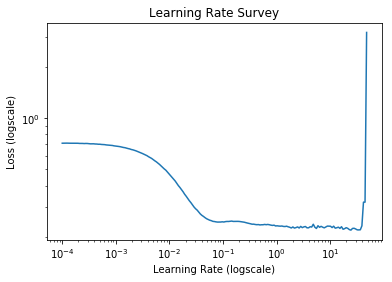

In [6]:
trainer.model.beta=0.15
survey_monitor = trainer.survey_learning_rate(
    num_epochs=10,
    min_learning_rate=1e-4,
    max_learning_rate=1e3,
    stop_factor=10)
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

24000/24000 [==============================] - 452s 19ms/step - loss: 0.1787 - val_loss: 0.1514


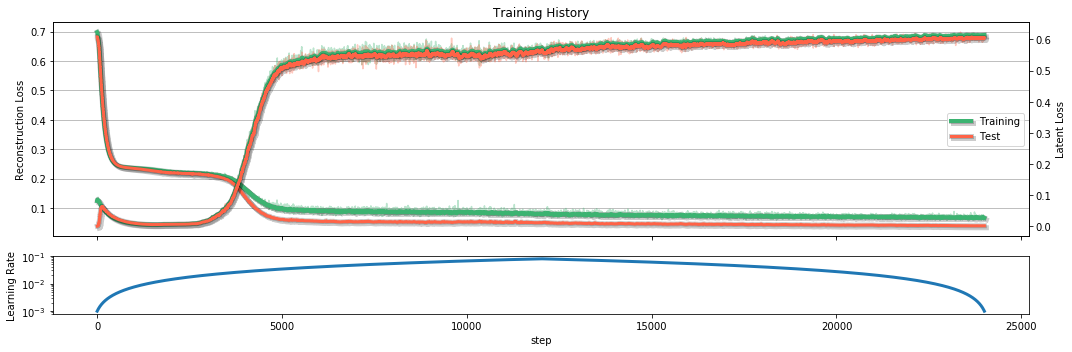

In [7]:
from sconce.rate_controllers import TriangleRateController
rate_controller = TriangleRateController(max_learning_rate=8e-2, min_learning_rate=1e-3)
monitor = trainer.train(num_epochs=1000, rate_controller=rate_controller)
monitor.dataframe_monitor.plot(skip_first=0, metrics=['reconstruction_loss', 'latent_loss']);

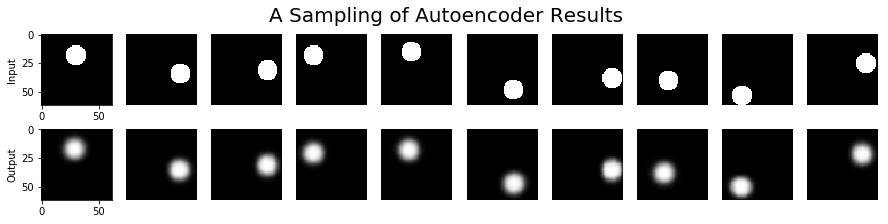

In [8]:
trainer.plot_input_output_pairs();

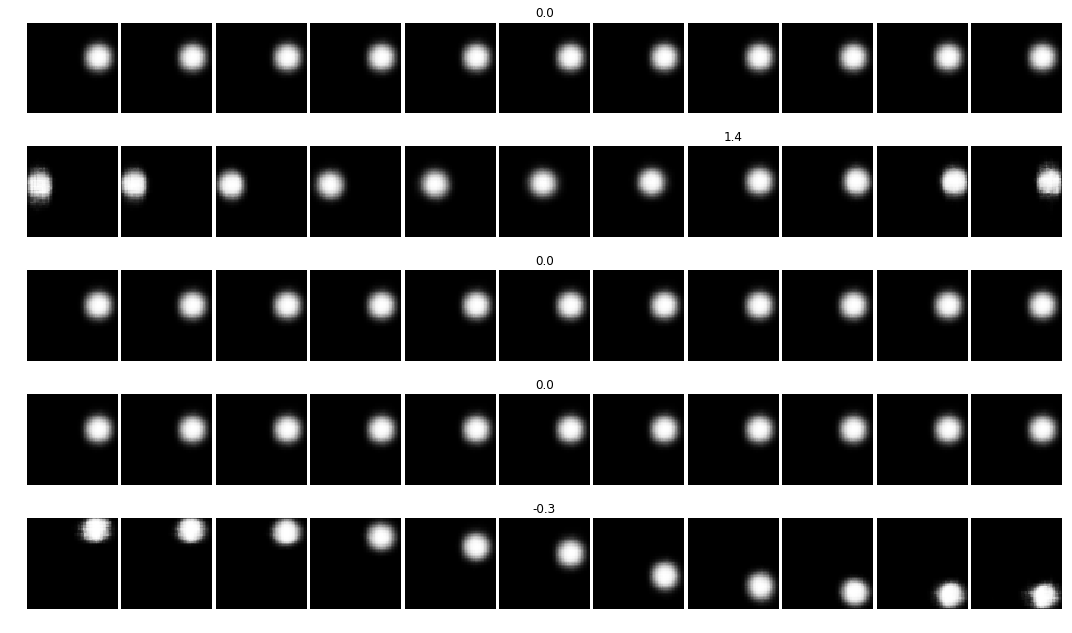

In [9]:
plot_trace(trainer, image_height=1.75)